# About

Here we prepare, plot (and save) the results for CI plots, which were obtained in:
- `colab_extended_ci_rf_and_gp_saving_results.ipnb`

The notebook includes both one-run and multiple-runs CIs plots

In [1]:
%ls

all_plots.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_ci_rf_and_gp_saving_results.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_and_plot_extended_ci_rf_and_gp_results.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [2]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original_IdSmilesLabels.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv


## Import modules

### Standard imports

In [3]:
import json
import pickle

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

### Custom imports

In [5]:
sys.path.insert(0, '..')

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, DPI, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels
from util_scripts.plotting_functions_and_vars import plot_algorithm_dataset_comparison_heatmap


from util_scripts.plotting_functions_and_vars import datasets_to_rounding_precision

sys.path.insert(0, './notebooks')

## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# sns.set()

# Load Data

## CHOOSE: dataset, smile_type, grid_search_type

In [7]:
dataset = 'esol'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

# correlated features treatment
if dataset == 'esol':
    cf = 'reduced'
else:
    cf = 'full'
assert cf in ['reduced', 'full']

In [8]:
# # for esol
cf = 'full'

## Titles, Units and Labels for datasets

In [9]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [10]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


In [11]:
for key, value in metrics_to_labels.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

RMSE          :  root-mean-square error
MAE           :  mean absolute error
R^2           :  R^2 (coefficient of determination)
pearson_r     :  Pearson correlation


In [12]:
rp = datasets_to_rounding_precision[dataset]
rp

2

## CHOOSE metric to display

In [13]:
metric = 'RMSE'
assert metric in metrics_to_labels

In [14]:
if metric in ['RMSE', 'MAE']:
    pass
else:
    # no units
    datasets_to_units = {'freesolv': '', 'esol': '', 'lipophilicity': ''}

## Choose model to show

In [15]:
model = 'gp'
assert model in ['rf', 'gp']

## Load files:

In [16]:
print(dataset, smile_type, grid_search_type, cf, model)

esol original extended full gp


In [17]:
# save results as csv-s, rewrite each time
df_true = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_{model}.csv')
df_pred = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_{model}.csv')
df_std = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_{model}.csv')

## Have a look at files

In [18]:
df_true.shape, df_pred.shape, df_std.shape

((226, 30), (226, 30), (226, 30))

In [19]:
df_true.head()

,test_true_0,test_true_1,test_true_2,test_true_3,test_true_4,test_true_5,test_true_6,test_true_7,test_true_8,test_true_9,...,test_true_20,test_true_21,test_true_22,test_true_23,test_true_24,test_true_25,test_true_26,test_true_27,test_true_28,test_true_29
0,-2.540,-0.010,-2.430,-5.05,-0.854,-0.620,-1.30,-1.140,-3.53,-3.770,...,-2.860,-3.893,-0.82,-4.883,-4.23,0.39,-0.73,-3.040,-2.60,-2.349
1,-2.253,-8.003,-6.510,0.47,-1.640,-2.060,-1.13,-5.370,-2.15,-4.560,...,-7.820,-4.220,-2.85,-4.432,-4.71,-5.16,0.96,-4.286,-5.37,-7.680
2,-2.484,-1.300,-4.194,-5.66,-6.290,-8.334,-3.39,-2.310,-3.59,-0.720,...,-2.843,-3.150,-1.29,-7.800,-2.96,-0.60,-4.06,-3.750,-2.22,-2.350
3,-2.540,-3.590,-4.000,-4.46,-2.350,-3.500,-0.41,-0.950,-1.78,-1.614,...,-1.220,-1.820,-4.15,-1.440,-2.46,-0.60,-1.08,-0.700,-2.64,-1.920
4,-7.200,-1.920,-2.452,-2.12,-1.890,0.523,-7.92,-2.468,-1.94,-4.140,...,-2.360,-6.090,-3.59,-4.140,-1.08,-3.85,-1.68,0.009,-3.40,1.120


In [20]:
df_pred.head()

,test_pred_0,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9,...,test_pred_20,test_pred_21,test_pred_22,test_pred_23,test_pred_24,test_pred_25,test_pred_26,test_pred_27,test_pred_28,test_pred_29
0,-2.574774,-0.092735,-2.359312,-4.921299,-0.444560,-0.723651,-1.312956,-0.817448,-3.222917,-4.055223,...,-3.699144,-4.848457,-1.200595,-3.139659,-3.965968,1.013075,-0.777772,-3.168655,-2.741790,-2.311988
1,-2.219771,-7.119158,-6.799538,0.187352,-1.494986,-2.033925,-2.794725,-5.211833,-1.541814,-3.951329,...,-8.076330,-3.292529,-2.684788,-4.475326,-4.179618,-4.384162,-0.390181,-3.960765,-5.234710,-7.947728
2,-2.637757,-1.481393,-4.564597,-4.850306,-3.316858,-6.369770,-2.743568,-2.326633,-3.943256,-0.870327,...,-2.364236,-4.041795,-1.298348,-7.405019,-2.806602,-0.625751,-3.901597,-3.664099,-1.568108,-2.195654
3,-2.574774,-4.001226,-4.130427,-5.114249,-2.169790,-4.189805,-0.049370,-1.746414,-1.878377,-1.724428,...,-1.502790,-0.823382,-4.225482,-2.299431,-2.459403,-0.491622,-1.104876,-0.833786,-2.415218,-0.727656
4,-6.848141,-2.724514,-2.577299,-2.556976,-1.740994,-0.742721,-8.591227,-2.480766,-1.821048,-4.455407,...,-2.445689,-5.463468,-3.467910,-4.212671,-1.278988,-3.428636,-1.728853,-0.319001,-3.507224,1.613903


In [21]:
df_std.head()

,test_std_0,test_std_1,test_std_2,test_std_3,test_std_4,test_std_5,test_std_6,test_std_7,test_std_8,test_std_9,...,test_std_20,test_std_21,test_std_22,test_std_23,test_std_24,test_std_25,test_std_26,test_std_27,test_std_28,test_std_29
0,0.374629,0.411988,0.402511,0.398874,0.445797,0.389197,0.435197,0.364603,0.457906,0.392631,...,0.888448,0.462549,0.369742,0.679346,0.399749,0.450585,0.389549,0.384639,0.479335,0.393712
1,0.422296,0.620047,0.450439,0.386145,0.428499,0.472384,0.778933,0.439689,0.597274,0.454309,...,0.397393,0.507070,0.483900,0.555781,0.621061,0.721696,0.761438,0.438246,0.455273,0.382036
2,0.476213,0.430429,0.557422,0.499846,0.985287,0.719856,0.487594,0.454743,0.447476,0.538235,...,0.412891,0.526371,0.395563,0.380757,0.470214,0.440016,0.421847,0.370015,0.786378,0.379015
3,0.374629,0.387415,0.409429,0.538187,0.404212,0.467853,0.891613,0.541868,0.430398,0.396403,...,0.643013,0.571402,0.395730,0.684369,0.461487,0.370116,0.375609,0.375388,0.392510,0.411440
4,0.401352,0.434015,0.429386,0.593062,0.399118,0.667212,0.416735,0.383654,0.387806,0.420823,...,0.462760,0.470339,0.847101,0.386102,0.417753,0.735935,0.446630,0.671971,0.391095,0.488479


# One run

In [22]:
y_test = df_true.iloc[:, 0]
y_test_pred = df_pred.iloc[:, 0]
y_test_std = df_std.iloc[:, 0]

## RMSE

In [23]:
mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)

0.5975255640640816

## Calculate confidence bounds using std part of gpr predictions

In [24]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [25]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper,
     'sq_error': (y_test - y_test_pred) ** 2
     }
)
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
display(CIs_df)

,y_test,y_test_pred,y_test_std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
107,-0.800,-0.864228,0.355617,-1.561238,-0.167218,0.004125,0.004125,0.004125,0.064228
70,-0.290,-0.326224,0.358591,-1.029063,0.376614,0.001312,0.005437,0.002719,0.052141
54,-1.170,-0.941271,0.358875,-1.644666,-0.237876,0.052317,0.057754,0.019251,0.138750
76,-1.980,-2.068488,0.359370,-2.772853,-1.364123,0.007830,0.065584,0.016396,0.128047
32,-3.740,-3.733691,0.361008,-4.441267,-3.026115,0.000040,0.065624,0.013125,0.114564
...,...,...,...,...,...,...,...,...,...
14,-3.380,-2.563632,0.826149,-4.182883,-0.944381,0.666457,79.339248,0.357384,0.597816
185,-3.800,-3.178221,0.871588,-4.886534,-1.469908,0.386609,79.725857,0.357515,0.597926
99,-0.410,-0.130140,0.872629,-1.840494,1.580213,0.078321,79.804178,0.356269,0.596882
73,-3.931,-4.514313,0.901840,-6.281919,-2.746707,0.340254,80.144432,0.356197,0.596823


In [26]:
# checking that calculating rmse each time separately would be the same
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)


calculation_match = []
for i in range(CIs_df.shape[0]):
    a = CIs_df.y_test[:i+1]
    b = CIs_df.y_test_pred[:i+1]
    
    calculation_match.append(np.abs(mean_squared_error(a, b, squared=False) - CIs_df.cumul_rmse.iloc[i]) < 1e-8)
    
# if returns true - it is the same
assert np.all(calculation_match) 

## Plot test observations with sdt values as colours

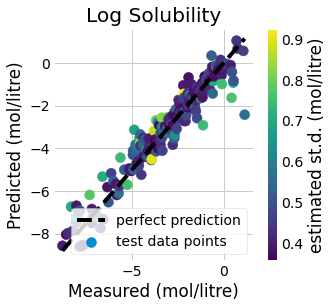

In [27]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test, y=CIs_df.y_test_pred, c=CIs_df.y_test_std, s=100, label='test data points')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

# add colourbar and legend
plt.colorbar(label=f'estimated st.d. {datasets_to_units[dataset]}')
plt.legend()

plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_scatter_colour_conf_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Plot sq^error vs std

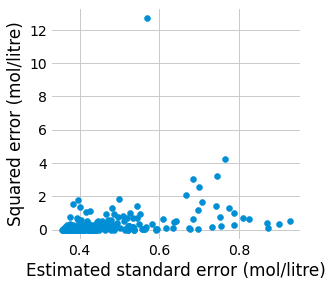

In [28]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

#plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test_std, y=CIs_df.sq_error)


plt.xlabel(f'Estimated standard error {datasets_to_units[dataset]}')
plt.ylabel(f'Squared error {datasets_to_units[dataset]}')
# plt.title(f'{datasets_to_titles[dataset]}')

# # add colourbar and legend
# plt.colorbar()
# plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

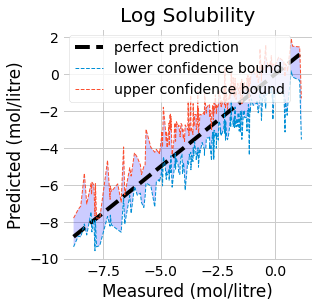

In [29]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

# ax.set_aspect('equal')

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)




ax.set_title(f'{datasets_to_titles[dataset]}')
ax.set_xlabel(f'Measured {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_with_ci_bounds_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [30]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis.sum() / len(within_cis)

0.9203539823008849

## Confidence plots (RMSE vs Prcentile)

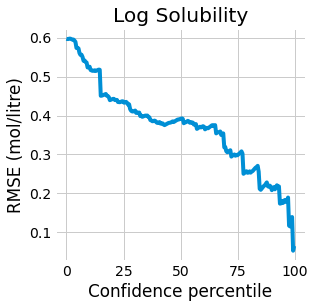

In [31]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)

# set size
plt.figure(figsize=FIGSIZE_CI)

confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]


plt.plot(confidence_percentiles, flipped_cumul_rmse)
plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_one_run_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [32]:
corr, p_value = pearsonr(confidence_percentiles, flipped_cumul_rmse)
corr, p_value

(-0.9577557642303136, 3.219674977448292e-123)

# Multiple runs

In [33]:
dataset_to_num_cis = {
    'freesolv': 50,
    'esol': 30,
    'lipophilicity': 10
}

In [34]:
dataset_to_num_cis[dataset]

30

In [35]:
rmse_mult_runs = []
within_95_cis_mult_runs = []
cumulrmse_vs_percentile_corr_mult_runs = []

flipped_cumulrmse_mult_runs = []

for i in range(dataset_to_num_cis[dataset]):
    
    # get data
    y_test = df_true.iloc[:, i]
    y_test_pred = df_pred.iloc[:, i]
    y_test_std = df_std.iloc[:, i]
    
    # calculate and record rmse
    rmse_mult_runs.append(mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False))
    
    # calculate upper and lower 95% conf bounds
    upper = y_test_pred + 1.96 * y_test_std
    lower = y_test_pred - 1.96 * y_test_std
    
    # calculate and record proportion of true values within 95% CI from prediction
    within_cis = (lower <= y_test) & (y_test <= upper)
    within_cis_proportion = within_cis.sum() / len(within_cis)
    within_95_cis_mult_runs.append(within_cis_proportion)
    
    # create a dataframe to be able to sort things easily
    CIs_df = pd.DataFrame(
        {'y_test': y_test,
         'y_test_pred': y_test_pred,
         'y_test_std': y_test_std,
         'lower': lower,
         'upper': upper,
         'sq_error': (y_test - y_test_pred) ** 2
        }
    )
    
    # create cumulative rmse column
    CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
    CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
    CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
    CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
    
    # record confidence percentiles and flip cumulative rmses
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
    flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]
    
    # record flipped cumulative rmse
    flipped_cumulrmse_mult_runs.append(flipped_cumul_rmse)
    
    # record correlation between cumulative rmse and confidence percentile
    cumulrmse_vs_percentile_corr_mult_runs.append(pearsonr(confidence_percentiles, flipped_cumul_rmse)[0])

print('Done')

Done


# Important metrics (corr, rmse, within_95)

In [36]:
dataset, cf, model

('esol', 'full', 'gp')

## Correlation

In [37]:
#cumulrmse_vs_percentile_corr_mult_runs

In [38]:
np.mean(cumulrmse_vs_percentile_corr_mult_runs).round(3), np.std(cumulrmse_vs_percentile_corr_mult_runs).round(3)

(-0.946, 0.027)

## RMSE

In [39]:
#rmse_mult_runs

In [40]:
np.mean(rmse_mult_runs).round(3), np.std(rmse_mult_runs).round(3)

(0.653, 0.063)

## Within 95% CIs

In [41]:
#within_95_cis_mult_runs

In [42]:
np.mean(within_95_cis_mult_runs).round(3), np.std(within_95_cis_mult_runs).round(3)

(0.922, 0.015)

# Separate plots (do not save)

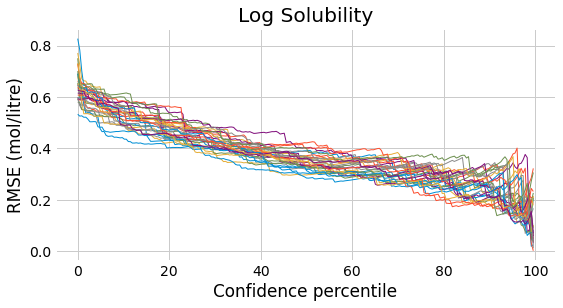

In [43]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    plt.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_mult_run_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()

# Calculations for Confidence Plot

In [44]:
#print(np.array(flipped_cumulrmse_mult_runs).shape)
#print(np.array(flipped_cumulrmse_mult_runs).std(axis=0).shape)
#print(np.array(flipped_cumulrmse_mult_runs).mean(axis=0).shape)

flipped_cumulrmse_mean = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)
flipped_cumulrmse_sdt = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)

flipped_cumulrmse_lower = flipped_cumulrmse_mean - 1.96*flipped_cumulrmse_sdt
flipped_cumulrmse_upper = flipped_cumulrmse_mean + 1.96*flipped_cumulrmse_sdt

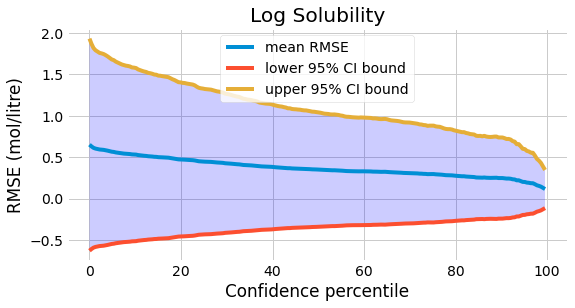

In [45]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

plt.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
plt.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
plt.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
plt.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

plt.legend(loc='upper center')

plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_with_ci_bounds_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Together

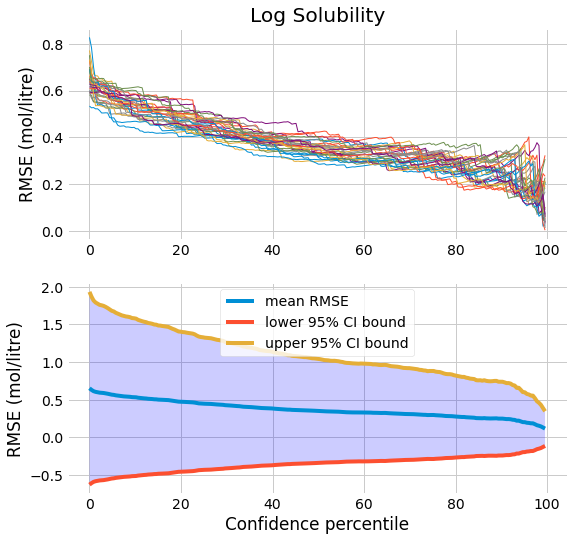

In [46]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) #, sharey=True

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    ax1.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

ax1.set_title(datasets_to_titles[dataset])
#ax1.set_xlabel('Confidence percentile')
ax1.set_ylabel(f'RMSE {datasets_to_units[dataset]}')


ax2.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
ax2.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
ax2.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
ax2.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

ax2.legend(loc='upper center')

#ax2.set_title(datasets_to_titles[dataset])
ax2.set_xlabel('Confidence percentile')
ax2.set_ylabel(f'RMSE {datasets_to_units[dataset]}')

plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_multiple_runs_both_{dataset}_{cf}.png', dpi=DPI, bbox_inches='tight')
plt.show()